# Skin Cancer Classification

### Import Relevant Packages

In [77]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import PIL.Image as img
from keras.layers import Dense, Conv2D , MaxPool2D , Dropout , Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import os
from glob import glob
import math
from imblearn import over_sampling, under_sampling
from IPython.display import display
import skimage

#### Data Overview:

This is the HAM10000 ("Human Against Machine with 10000 training images") dataset -- a dataset aggregated by Harvard Medical School with the express purpose of building machine learning models. As such, the data is clean, organized, and ready for analysis. It consists of 10015 images, each a dermatoscopic image of a skin lesion belonging to one of seven classes (a list of classes and their numeric representation in the dataset is given below). Notably, the 4th category is a mix of 3 separate diagnoses, which likely explains the imbalance we uncover in our analysis. 

Lesion Categories:
```
0: nv - Melanocytic nevi
1: mel - Melanoma
2: bkl - Benign keratosis-like lesions
3: bcc - Basal cell carcinoma
4: akiec - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
5: vasc - Vascular lesions
6: df - Dermatofibroma
```
#### Roadmap:

Convolutional Neural Networks (CNN) have demonstrated high performance on image classification tasks, especially tasks which require distinction between fine-grained categories. Skin cancers present few visually distinctive qualities from other subgroups of cancerous lesions, and can sometimes be misdiagnosed as benign. Our approach uses a single CNN trained solely on images and using only pixels and labels as inputs. Our CNN performs on par with state-of-the-art models, demonstrating a level of competence comparable to dermatologists and doing so with one-tenth of the data and roughly half of the computational demand.

Our analysis is broken into several parts, each labeled with a bold headline. A short index with clickable links follows:

**Index**

[Read in Dataset](#Read_in_Dataset) -- Pulls dataset from computer.

[Metadata Analysis](#Metadata_Analysis) -- A short exploratory analysis of the data. 

[Merge Datasets](#Merge_Datasets) -- Consolidation of image paths and metadata.

[Image Plots, Confirmatory](#Plot_Images_From_Modified_Data) -- Confirms image paths and checks image size.

[Image Plots, Exploratory](#Further_Exploration_&_Plotting) -- A wider variety of images and metadata plots.

[Training / Testing Split; Preprocessing](#Training_/_Testing_Split) -- Splits data into 70/30; creates preprocessing algorithm and explanatory plots.

[ImageDataGenerator](#Flow_From_Dataframe) -- Data augmentation and model generator. Allows memory-efficient image processing.

[Over/Under Sampling](#Over_and_UnderSampling_Data) -- Oversamples data and creates exploratory plots, provides sample for undersampling (not used).

[Class Weight Adjustments](#Class_Weight_Adjustments) -- Generates weights for lesion classes in dataframe.

<p style = "color:red"> NOTE: No cells beneath this point have outputs given limited computational resources.</p>

[Model Architecture](#Model_Architecture) -- Provides several code samples for different architectures, as well as final architecture.

[Model Plots](#Model_Plots) -- Provides code sample for plots used in presentation.

## Read in Dataset
<a id='Read_in_Dataset'></a>

In [109]:
data = pd.read_csv("./data/hmnist_28_28_L.csv")
metadata = pd.read_csv("./data/HAM10000_metadata.csv")

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Metadata Analysis

<a id='Metadata_Analysis'></a>

In [79]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Good to know! It looks like we've got 57 cases whose age was not recorded. This is a relatively low number so we can replace these missing ages with the mean age across the whole dataset. I'm using imputation rather than removal because I want to use as much available data as possible. 

In [80]:
# Fill na values "age" variable
metadata["age"].fillna(metadata["age"].mean(), inplace = True)
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [81]:
# Check work with .describe:
metadata["age"].describe()

count    10015.000000
mean        51.863828
std         16.920252
min          0.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

Interesting... we have some cases where the recorded age is zero!! It's unlikely (I think, at least; I'm not really an expert in pediatric oncology) to have a patient who is truly less than a year old in for skin cancer, so I'm going to assume that these cases are simply a mixup in data entry -- some unknown ages were input as NA, some unknown ages were input as 0. Let's fix that too.

#### First, let's check how many 0s we have....

In [82]:
metadata["age"].value_counts()[0]

39

39 zeros is an acceptable number -- we replace these values with the mean.

In [83]:
metadata["age"] = metadata["age"].replace(0, metadata["age"].mean())
metadata["age"].describe()

count    10015.000000
mean        52.065794
std         16.606576
min          5.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

In [84]:
data.groupby("label").count()["pixel0001"]

label
0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
Name: pixel0001, dtype: int64

This data is imbalanced! Clearly, there are some categories that are overrepresented in our data; we'll need to take this into as we progress through the project.  

## Merge Datasets
<a id='Merge_Datasets'></a>

I want to make sure that I can keep all data contained in the same dataframe so we can perform a more detailed analysis. I've decided to provide specific names for each skin lesion abbreviation to make my visualizations clearer, and included the image path in the dataframe to make it simpler to find and plot images. I add the label column because each skin lesion is associated with a numeric label code in the pre-built image arrays. In the event I want to use one of these other datasets, I want the switch to be as smooth as possible. Moreover, I will need to one-hot encode the label column to use it in a CNN like I intend to, and readability is helped by making similar changes all at the same time.

In [85]:
# Create lesion type dataset:

cancer_types_dict = {
    "akiec" : "Actinic Keratoses",
    "bcc" : "Basal Cell Carcinoma",
    "bkl" : "Benign Keratosis-like Lesions",
    "df" : "Dermatofibroma",
    "mel" : "Melanoma",
    "nv" : "Melanocytic Nevi",
    "vasc" : "Vascular Lesions"
}

# Create dict of img paths:
base_skin_set = os.getcwd() # Note: the file must be in the "data" folder!

image_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_set, '*', '*.jpg'))} 

In [86]:
# Create modified dataframe:
mod_data = metadata

mod_data["Cell_Type"] = mod_data['dx'].map(cancer_types_dict.get)
mod_data["Path"] = mod_data["image_id"].map(image_id_path_dict.get)
mod_data["Label"] = pd.Categorical(mod_data['Cell_Type']).codes # Aligns data labels with .csv files in original download
mod_data.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,Cell_Type,Path,Label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign Keratosis-like Lesions,C:\Users\new owner\Documents\GitHub\fluffy-dis...,2


In [87]:
# Check for NA values in "Path"
print(mod_data[mod_data["Path"].isna()])

# Create Copy Data
copy_data = mod_data

Empty DataFrame
Columns: [lesion_id, image_id, dx, dx_type, age, sex, localization, Cell_Type, Path, Label]
Index: []


Excellent -- we've consolidated image information and the images themselves in the dataframe. We also created an exact copy of "mod_data" to distinguish dataframes for plotting and use in classification. In this way, we ensure no cross contamination that could affect model performance. 

### Plot Images From Modified Data
<a id='Plot_Images_From_Modified_Data'></a>

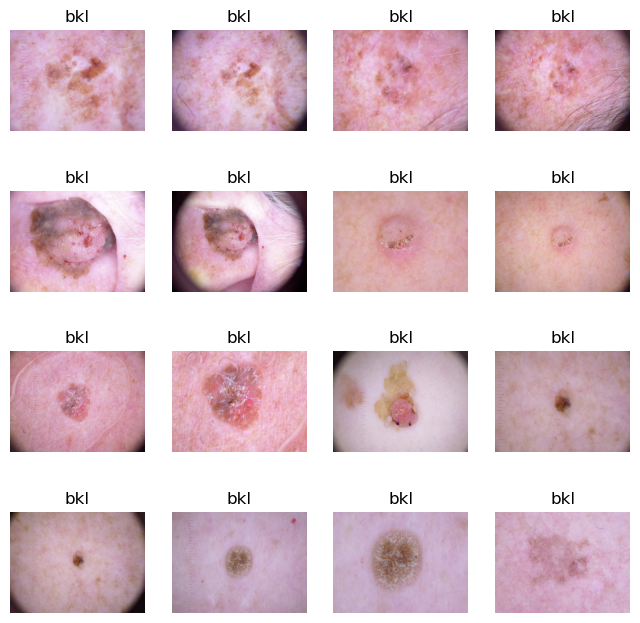

In [88]:
plt.figure(figsize = (8,8))

for i in range(16):
    plt.subplot(4,4, i + 1)
    x = plt.imread(mod_data.Path[i])
    plt.axis("off")
    plt.title(mod_data.dx[i])
    plt.imshow(x)

This image is proof of concept, running quickly to ensure that images can be easily displayed and acting as confirmation that we can draw information from the image paths contained in mod_data

In [89]:
# Let's check our incoming image size:
image = img.open(mod_data["Path"][0])
print(f"Image Size: {image.size}")

Image Size: (600, 450)


Good to know -- this is likely to be to big to be efficient given our limitations. We'll need to resize.

### Further Exploration & Plotting
<a id = "Further_Exploration_&_Plotting" ></a>

['Benign Keratosis-like Lesions' 'Melanocytic Nevi' 'Dermatofibroma'
 'Melanoma' 'Vascular Lesions' 'Basal Cell Carcinoma' 'Actinic Keratoses']
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


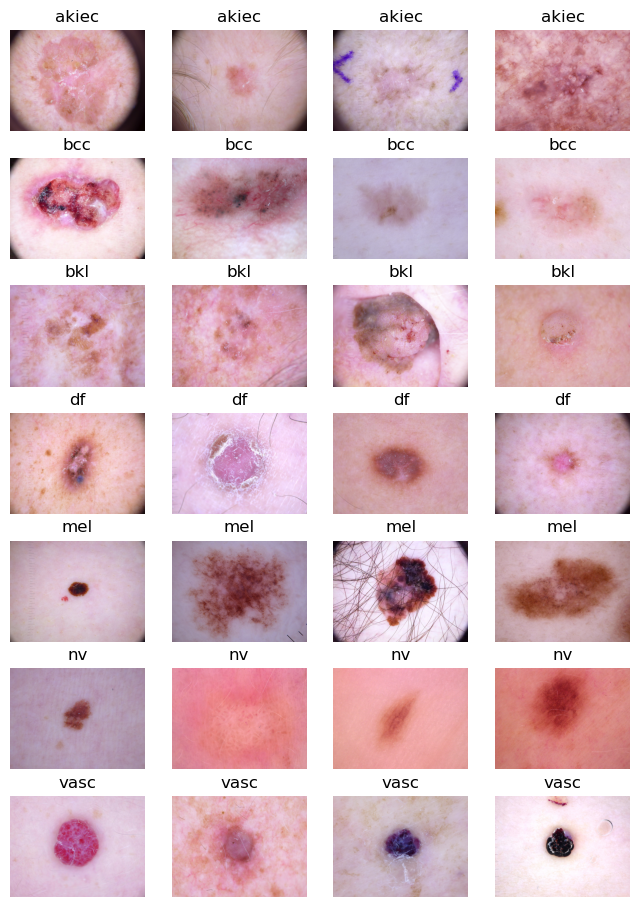

In [90]:
unq_lesions = copy_data.drop_duplicates(subset=['lesion_id'])
print(copy_data['Cell_Type'].unique())
print(unq_lesions['dx'].unique())

#select the indexes of the pictures we want
start_data = np.unique(unq_lesions['dx']) #number of lesions
indexes = []

def find_index(i):
    temp_df = unq_lesions[unq_lesions['dx']== start_data[i]]
    for i in range(4):
        indexes.append(temp_df.index[i])
    return

for i in range(len(start_data)):
    find_index(i)
    
#dataframe of just the images I want and their info
images_df = pd.DataFrame()
for i in range(len(indexes)):
    images_df[i] = unq_lesions.loc[indexes[i]]
    
plt.figure(figsize = (8,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)
for i in range(28):
    plt.subplot(7,4, i + 1)
    x = plt.imread(images_df.at['Path', i])
    plt.axis("off")
    plt.title(images_df.at['dx', i])
    plt.imshow(x)

This plot was used in the presentation, displaying all categories of our lesions.

C:\Users\new owner\AppData\Local\Temp\ipykernel_9824\3715053238.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unq_lesions["age"] = unq_lesions["age"].replace(unq_lesions.iloc[i, :]['age'], 50)


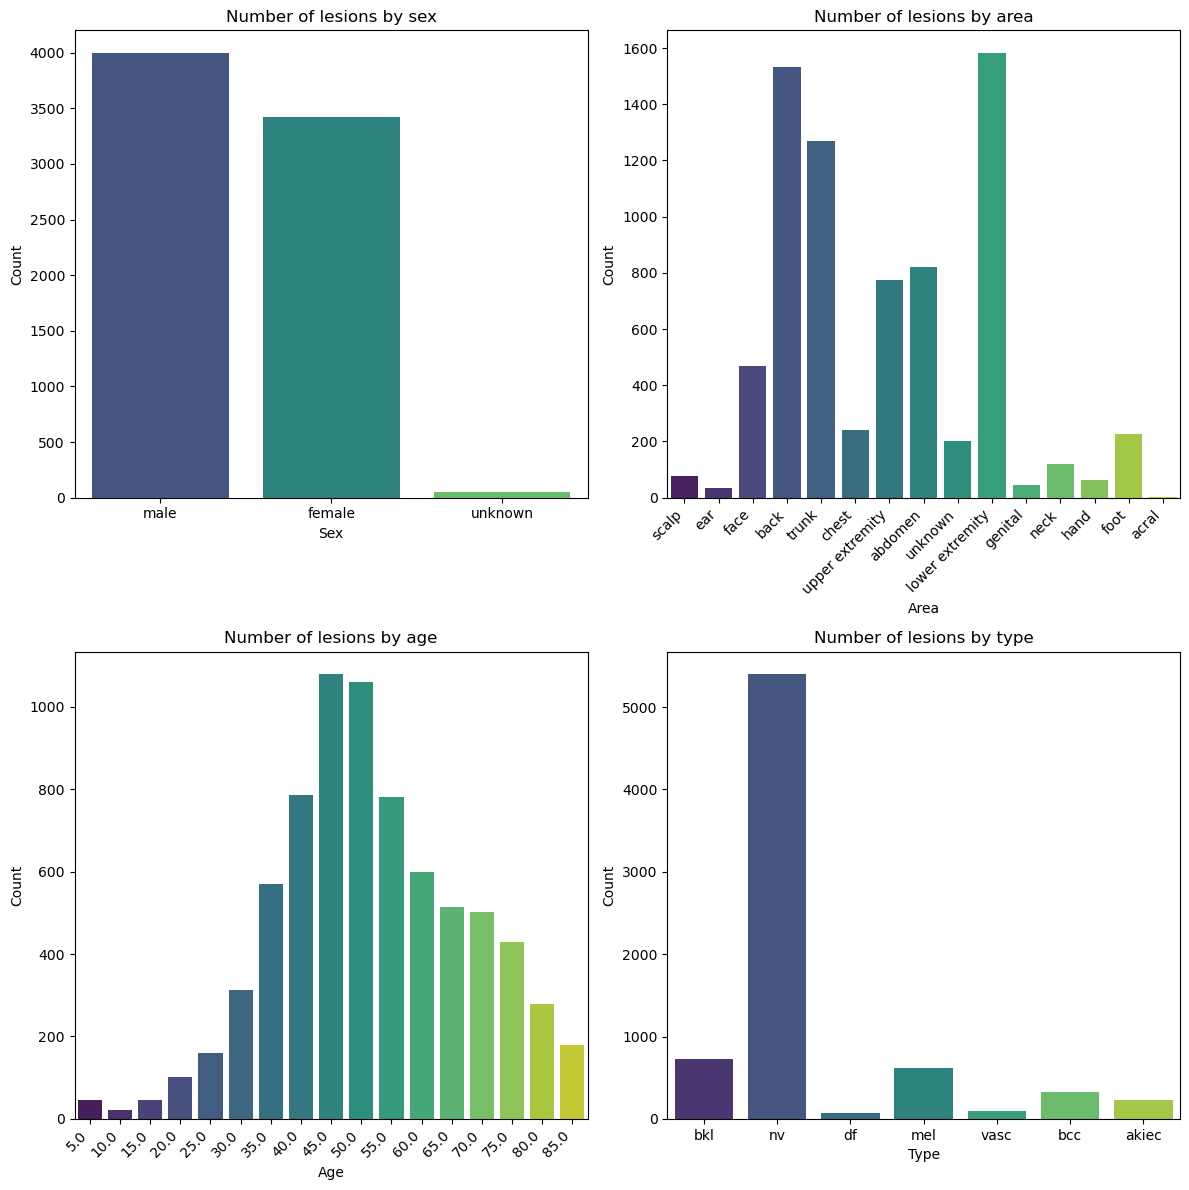

In [91]:
#color defines the palette you want to use
#so far i like pastel and bright better than the original, but
#viridis and magma are coolest
color='viridis'
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

sns.countplot(x = "sex", data = unq_lesions, ax=ax1, palette=color)
ax1.set_title('Number of lesions by sex')
ax1.set_xlabel('Sex')
ax1.set_ylabel('Count')

sns.countplot(x='localization', data=unq_lesions, ax=ax2, palette=color)
ax2.set_title('Number of lesions by area')
ax2.set_xlabel('Area')
ax2.set_ylabel('Count')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')

#move values labeled at 51 to 50
for i in range(len(unq_lesions['age'])):
    if unq_lesions.iloc[i, :]['age'] > 51 and unq_lesions.iloc[i, :]['age'] < 52:
        unq_lesions["age"] = unq_lesions["age"].replace(unq_lesions.iloc[i, :]['age'], 50)
sns.countplot(x = 'age', data=unq_lesions, ax=ax3, palette=color)
ax3.set_title('Number of lesions by age')
ax3.set_xlabel('Age')
ax3.set_ylabel('Count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.countplot(x = "dx", data=unq_lesions, ax=ax4, palette=color)
ax4.set_title('Number of lesions by type')
ax4.set_xlabel('Type')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()

Metadata exploration, illustrating lesion density by sex, age, type, and area.

### Training / Testing Split
<a id = "Training_/_Testing_Split"></a>

In [92]:
# Split into Train and Test sets
Train_dataframe, Test_dataframe = train_test_split(mod_data, test_size = .3, stratify = mod_data["Label"]) # 70-30 split

display(print(np.unique(Train_dataframe["dx"])), print(np.unique(Test_dataframe["dx"])))

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


None

None

We've found that we need to ensure proportional representaion of all classes in the training and testing set to prevent the CNN from returning awful performance on the evaluation. Thus, we pre-split the data into training and testing sets, stratifying along the "Label" category. The stratify parameter is ensuring that the random split of this dataset has the same proportions of class labels as the input dataset -- if we have 75% "1" and 25% "0", the train and test datasets will have 75% "1" and 25% "0" in each dataframe. This is good for what we need, which is making sure that we are showing the model everything it'll encounter in the testing set. 

In [93]:
# Define Preprocessing Function

### Note to Self: Add Edge detection, Vignette detection / cropping. 

def preprocess(input_image):
  image1 = input_image
  grey = greyscale(image1)
  contrast = apply_contrast(grey)
  blurred = blur(contrast)
  threshold = skimage.filters.threshold_mean(blurred)
  mask = blurred < threshold
  image1[~mask] = 0
  return image1

def greyscale(image):
  image = skimage.color.rgb2gray(image)
  #for clr in range(image.shape[2]):
  #  image[:,:,clr]=image.mean(axis=2)
  return image

def apply_contrast(image):
  percentiles = np.percentile(image, (0.5, 99.5))
  # array([ 1., 28.])
  #image_dark = skimage.exposure.adjust_gamma(image, gamma=1.5,gain=1)
  image_bright = skimage.exposure.adjust_gamma(image, gamma=0.5,gain=1)
  scaled = skimage.exposure.rescale_intensity(image_bright,
                                    in_range=tuple(percentiles))
  return scaled

def blur(image):
  blurred_image = skimage.filters.gaussian(image, sigma=1.0)
  return blurred_image


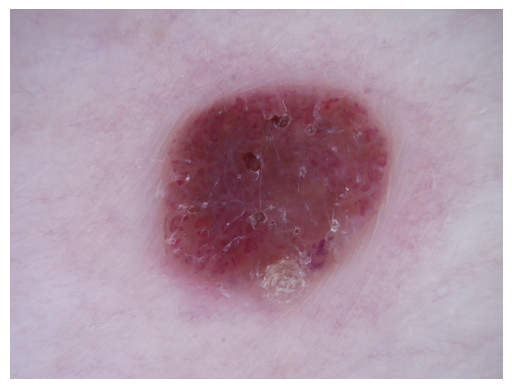

In [94]:
x = np.array(plt.imread(mod_data.Path[121]))
ximage = img.fromarray(x)
plt.axis("off")
gray = greyscale(ximage)
contrast = apply_contrast(gray)
blurred = blur(contrast)
display(plt.imshow(ximage, cmap = "gray"))
plt.savefig("imgone.png")

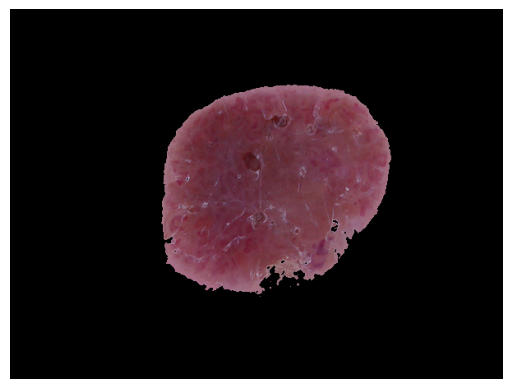

In [95]:
x = np.array(plt.imread(mod_data.Path[121]))
ximage = img.fromarray(x)
y = preprocess(x)
yimage = img.fromarray(y)
#color_img = cv2.cvtColor(y, cv2.COLOR_GRAY2RGB) 
plt.axis("off")
plt.imshow(yimage)

Our preprocessng algorithm is essentially another means of feature selection; we simply take everything out of the model that isn't a lesion. We do this by adjusting contrast, brightness, and blur to separate the lesion from its background. It is important to note, however, that this will not work on black skin. Our data does not include any images of lesions on black skin, so our methodology does not confund our results, but it is an important fact to keep in mind. 

### Flow From Dataframe
<a id = "Flow_From_Dataframe"></a>

In [96]:
# Flow From Dataframe
from keras.preprocessing.image import ImageDataGenerator

# Create Train Generator 
train_gen = ImageDataGenerator(rescale = 1.0 / 255, preprocessing_function = preprocess, horizontal_flip = True,
                              vertical_flip = True, brightness_range = [0.2,1.0], zoom_range = [0.5,1.0])

# Create Test Generator
test_gen = ImageDataGenerator(rescale = 1.0 / 255, preprocessing_function = preprocess)

# Training
x_gen = train_gen.flow_from_dataframe(dataframe = Train_dataframe, x_col = "Path", y_col = "dx", target_size = (128, 128), batch_size = 32,
                                class_mode = "categorical", shuffle = True, seed = 1729)
# Testing
y_gen = test_gen.flow_from_dataframe(dataframe = Test_dataframe, x_col = "Path", y_col = "dx", target_size = (128, 128), batch_size = 32,
                                class_mode = "categorical", seed = 1729)

Found 7010 validated image filenames belonging to 7 classes.
Found 3005 validated image filenames belonging to 7 classes.


This code draws from the dataframe "mod_data", selecting the image path as the variable and dx as the label, one-hot enocoding the label in the process. The image is reshaped to (128, 128) and normalized so values are between 0 & 1. The validation split is 70-30; I intend to draw from a harvard repository of similar skin cancer images as a final testing set. This draws the images in a more memory efficient manner than the .map(lambda: x ...) stratagem I employed earlier. We also introduce strong augmentation in the training generator to reduce the risk of overfitting, employing brightness and zoom shifts, rotations, and flips. 

### Over and UnderSampling Data

<a id = "Over_and_UnderSampling_Data"></a>

So, here's where we stand. Right now, we've got all the data fixed up and in a position where we can start building a model, but there's still a problem here. We have massive class imbalances in this dataset; Melanocytic Nevi makes up more than HALF of our samples! Ergo, we're going to test over and undersampling out to see how they look.

In [97]:
# This block of code oversamples the data

# Define number of classes
CLASSES = len(np.unique(Train_dataframe["Cell_Type"]))

# Individual class probabilities in dataset
display(print("Invidual Probabilities:"), Train_dataframe["Cell_Type"].value_counts() / len(Train_dataframe))

# Ideal uniform class probability
display(print("Ideal Uniform:"), 1 / CLASSES)

# Resample data to even class probabilies
oversample = over_sampling.RandomOverSampler()
Train_dataframe1, Train_dataframe1_y = oversample.fit_resample(Train_dataframe, Train_dataframe["Label"])
Test_dataframe1, Test_dataframe1_y = oversample.fit_resample(Test_dataframe, Test_dataframe["Label"])

# Display Resampled Probs.
display(print("Invidual Probabilities After Resampling:"), Train_dataframe1["Cell_Type"].value_counts() / len(Train_dataframe1))



Invidual Probabilities:


None

Melanocytic Nevi                 0.669472
Melanoma                         0.111127
Benign Keratosis-like Lesions    0.109700
Basal Cell Carcinoma             0.051355
Actinic Keratoses                0.032668
Vascular Lesions                 0.014123
Dermatofibroma                   0.011555
Name: Cell_Type, dtype: float64

Ideal Uniform:


None

0.14285714285714285

Invidual Probabilities After Resampling:


None

Melanocytic Nevi                 0.142857
Melanoma                         0.142857
Benign Keratosis-like Lesions    0.142857
Basal Cell Carcinoma             0.142857
Dermatofibroma                   0.142857
Vascular Lesions                 0.142857
Actinic Keratoses                0.142857
Name: Cell_Type, dtype: float64

Oversampling works well -- it simulates a balanced dataset by sampling with replacement. 

<AxesSubplot: xlabel='Label', ylabel='count'>

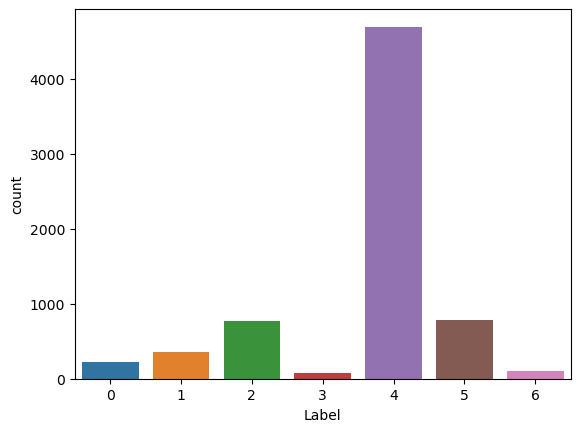

In [98]:
sns.countplot(x = "Label", data = Train_dataframe)

Our original class balances... not a pretty sight.

<AxesSubplot: xlabel='Label', ylabel='count'>

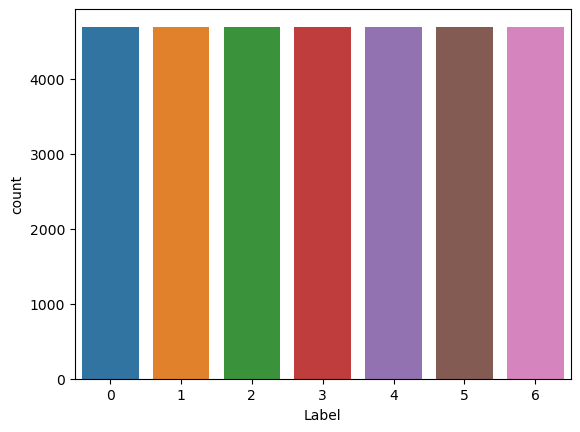

In [99]:
sns.countplot(x = "Label", data = Train_dataframe1)

There we go! That looks much better. 

In [100]:
# This block of code undersamples the data
"""
CLASSES = len(np.unique(mod_data["Cell_Type"]))

# Individual class probabilities in dataset
display(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))

undersampler  = under_sampling.RandomUnderSampler()

mod_data, mod_data["Label"] = undersampler.fit_resample(mod_data, mod_data["Label"])

# Display Resampled Probs.
display(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))
"""

'\nCLASSES = len(np.unique(mod_data["Cell_Type"]))\n\n# Individual class probabilities in dataset\ndisplay(print("Invidual Probabilities:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n\nundersampler  = under_sampling.RandomUnderSampler()\n\nmod_data, mod_data["Label"] = undersampler.fit_resample(mod_data, mod_data["Label"])\n\n# Display Resampled Probs.\ndisplay(print("Invidual Probabilities After Resampling:"), mod_data["Cell_Type"].value_counts() / len(mod_data))\n'

Undersampling the data, on the other hand, limits us to 805 datapoints; not nearly enough to train any kind of robust model. 

### Class Weight Adjustments

<a id = "Class_Weight_Adjustments"></a>

There's a couple of things I'll need to clean up here. First, I'm setting the class weights to "balanced", which uses the following formula to calculate weight:
\begin{equation*}
\frac{n_{samples}}{n_{classes} \cdot \operatorname{bincount}(y)}
\end{equation*}
In short, class weights are the inverse of the the expectations. Class weights allow us to assign importance to images as they are pulled from each class.

In [101]:
"""
# Set Class Weights
class_weights = np.around(class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(mod_data["Label"]), y = mod_data["Label"]), 2)

# Zip to dict indexed by label
class_weights = dict(zip(np.unique(mod_data["Label"]), class_weights))
print(class_weights)
"""

'\n# Set Class Weights\nclass_weights = np.around(class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(mod_data["Label"]), y = mod_data["Label"]), 2)\n\n# Zip to dict indexed by label\nclass_weights = dict(zip(np.unique(mod_data["Label"]), class_weights))\nprint(class_weights)\n'

In [102]:
# Compute Class Weights and Store in Dict

labelcount = {}
labels = np.unique(mod_data["Label"])

for label in labels:
    x = ((1 / np.count_nonzero(mod_data["Label"] == label)) * (len(mod_data) / 2))
    labelcount[label] = x 

labelcount


{0: 15.313455657492355,
 1: 9.742217898832685,
 2: 4.556414922656961,
 3: 43.54347826086956,
 4: 0.7468307233407905,
 5: 4.499101527403415,
 6: 35.264084507042256}

### Model Architecture

<a id = "Model_Architecture"></a>

We have several different architectures below, however we only used the final. The others either had structural issues or poor performance, we include them solely to outline the process we took to developing our model.

<div class = "alert-block alert-danger alert">
    <b> NO CODE BELOW THIS POINT WILL HAVE OUTPUT. <br> <b>
    <b> We provide only code samples of the following blocks because of the computational limitations placed on us by the nature of our model.<b>
        </div>

In [103]:
"""
input_shape = (128, 128, 3)
num_classes = 7

model = models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
"""

"\ninput_shape = (128, 128, 3)\nnum_classes = 7\n\nmodel = models.Sequential()\nmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))\nmodel.add(MaxPool2D(pool_size = (2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))\nmodel.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))\nmodel.add(MaxPool2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.40))\n\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(num_classes, activation='softmax'))\nmodel.summary()\n"

In [104]:
"""
model = models.Sequential()
        

model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (128, 128, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))


model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="valid"))
model.add(tf.keras.layers.BatchNormalization())


model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())


model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(tf.keras.layers.BatchNormalization())

model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten()) 

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.4))
              
model.add(Dense(7, activation = 'softmax'))
model.summary()
"""

'\nmodel = models.Sequential()\n        \n\nmodel.add(Conv2D(filters = 96,\n                kernel_size = (11, 11),\n                strides = (4, 4),\n                activation = \'relu\',\n                input_shape = (128, 128, 3)))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))\n\n\nmodel.add(Conv2D(filters = 256,\n                kernel_size=(5, 5),\n                strides=(1, 1),\n                activation = \'relu\',\n                padding = "same"))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))\n\n\nmodel.add(Conv2D(filters = 384,\n                 kernel_size=(3,3),\n                 strides=(1,1),\n                 activation=\'relu\',\n                 padding="valid"))\nmodel.add(tf.keras.layers.BatchNormalization())\n\n\nmodel.add(Conv2D(filters = 384,\n                kernel_size = (1, 1), \n                strides = (1, 1), \n                

In [105]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import plot_model

# Instantiate Class Inception

class Inception(tf.keras.Model):
    # Channel refers to the specific output channel for each branch; please note that channels 2 & 3 must be given as tuples.
    def __init__(self, channel1, channel2, channel3, channel4):
        super().__init__() 
        self.branch1_1 = tf.keras.layers.Conv2D(channel1, 1, activation = "relu") # Note that we add a 1x1 convolution
        self.branch2_1 = tf.keras.layers.Conv2D(channel2[0], 1, activation = "relu")
        self.branch2_2 = tf.keras.layers.Conv2D(channel2[1], 3, activation = "relu", padding = "same")
        self.branch3_1 = tf.keras.layers.Conv2D(channel3[0], 1, activation = "relu")
        self.branch3_2 = tf.keras.layers.Conv2D(channel3[1], 5, activation = "relu", padding = "same")
        self.branch4_1 = tf.keras.layers.MaxPooling2D(pool_size = 3, strides = 1, padding = "same")
        self.branch4_2 = tf.keras.layers.Conv2D(channel4, kernel_size = 1, activation = "relu")
        
    def call(self, x):
        branch1 = self.branch1_1(x)
        branch2 = self.branch2_2(self.branch2_1(x))
        branch3 = self.branch3_2(self.branch3_1(x))
        branch4 = self.branch4_2(self.branch4_1(x))
        output = tf.keras.layers.Concatenate()([branch1, branch2, branch3, branch4])
        return output
            
            
            
            

An inception block operates by convolving over the image simultaneously -- this one, taking inspiration from GoogleNet, convolves with 1x1, 3x3, and 5x5 kernels. All activation functions are ReLu activations, and branches are concatonated before the output is returned.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        4160      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 192)     

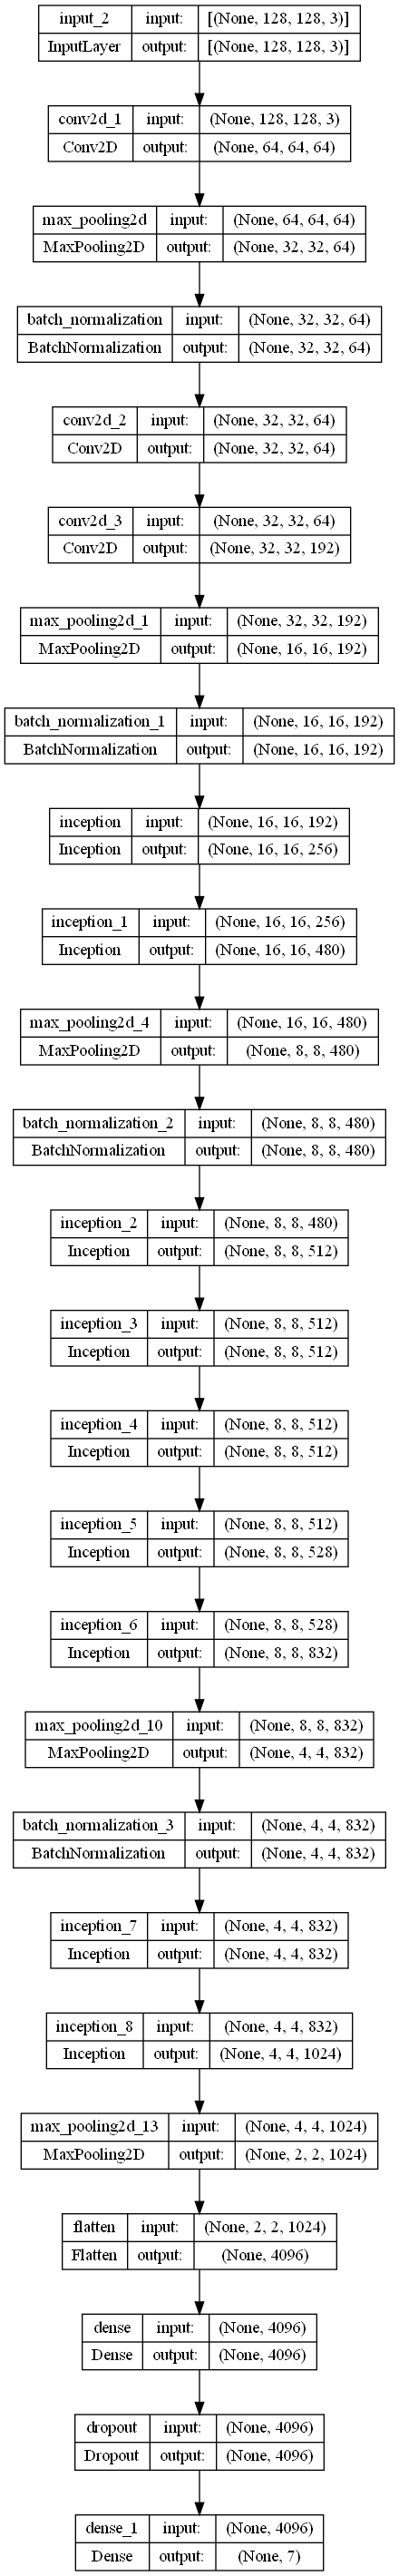

In [106]:
model = models.Sequential()

# Block One
model.add(tf.keras.layers.Input(shape = (128, 128, 3)))
model.add(Conv2D(64, kernel_size = 7, strides = 2, activation = "relu", padding = "same")) # 7x7, with kernel overlap
model.add(MaxPooling2D(pool_size = 3, strides = 2, padding = "same"))
model.add(tf.keras.layers.BatchNormalization())

# Block Two
model.add(Conv2D(64, kernel_size = 1, activation = "relu"))
model.add(Conv2D(192, kernel_size = 3, activation = "relu", padding = "same")) # 3x3 kernel; triples channels
model.add(MaxPooling2D(pool_size = 3, strides = 2, padding = "same"))
model.add(tf.keras.layers.BatchNormalization())

# Block Three
model.add(Inception(64, (92, 128), (16, 32), 32))
model.add(Inception(128, (128, 192), (32, 96), 64))
model.add(MaxPooling2D(pool_size=3, strides=2, padding= "same"))
model.add(tf.keras.layers.BatchNormalization())

# Block Four
model.add(Inception(192, (96, 208), (16, 48), 64))
model.add(Inception(160, (112, 224), (24, 64), 64))
model.add(Inception(128, (128, 256), (24, 64), 64))
model.add(Inception(112, (144, 288), (32, 64), 64))
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(MaxPooling2D(3, 2, padding = "same"))
model.add(tf.keras.layers.BatchNormalization())

# Block Five
model.add(Inception(256, (160, 320), (32, 128), 128))
model.add(Inception(384, (192, 384), (48, 128), 128))
model.add((MaxPooling2D()))
model.add(tf.keras.layers.Flatten())
model.add(Dense(4096, activation = "relu"))
model.add(Dropout(.4))
model.add(Dense(7, activation = "softmax"))

# Summary & Plot
model.summary()
keras.utils.plot_model(model, show_shapes = True)

In [107]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)

In [74]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            learning_rate=0.00001)

#### I have commented out the models themselves for an easy delivery. They are given in the following two cells:

In [69]:
#epochs = 25
#history = model.fit(x_gen, epochs = epochs, callbacks = [early_stopping, learning_rate_reduction], 
#                    class_weight = labelcount)

This model draws from the generators defined above, using class weights to offset the most powerful forces of the data's imbalance. This model achieved the 76% accuracy rate as described in our presentation.

In [70]:
#history1 = model.fit_generator(train_gen.flow_from_dataframe(dataframe = Train_dataframe1, x_col = "Path", y_col = "dx", target_size = (128, 128), batch_size = 32,
#                                class_mode = "categorical", shuffle = True, seed = 1729, validation_data = (Test_dataframe1, Test_dataframe1_y)),
#                              verbose = 1, steps_per_epoch=Train_dataframe1.shape[0] // batch_size
#                              , callbacks=[learning_rate_reduction], epochs = epochs)

This model simulates a balanced dataframe by oversampling the data. This model achieved a 91% accuracy rate. 

### Model Plots
#### Below are the code cells for plots used in the presentation. All output has been cleared as they are dependent on the model.

<a id = "Model_Plots"></a>

In [75]:
 def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix, Training Dataset',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:

Y_pred = model.predict(Test_dataframe1)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Test_dataframe1_y,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [ ]:
y_score = model.predict(x_test)

sklearn.metrics.RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_score.ravel(),
    color="darkorange"
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.savefig("Micro-averaged ROC",figsize = (10, 10),dpi = 1200)
plt.show()

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')